# **Pre-process Coronavirus Music Questionnaire (CMQ) data**

The goal of this Jupyter Notebook is to clean the data from all different survey versions (languages) in Qualtrics.

We have around 1000 survey responses from Germany, Italy, France, India, New York, and the UK. Though the survey questions were almost identical in all versions, there are a few differences that need to be handled. 

We also need to get all question responses into useable formats and to remove any participants who were not taking the study seriously. 

LW + LF

# **Load required packages and modules**

In [1]:
# basic coding/ML tools
import numpy as np
import math
import pandas as pd
import os, sys, scipy, xlrd, urllib, itertools, re, warnings
from pandas.api.types import CategoricalDtype

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns, IPython.display
from IPython.display import Image, HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)

warnings.filterwarnings(action='ignore')

# Local imports
import local_dicts # dictionary defining column labels for our dataframe and answer text~answer code relationships 
import local_funcs # functions that we might want to use in multiple scripts throughout the project
import importlib

importlib.reload(local_dicts) 
importlib.reload(local_funcs)

# display all columns in dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load and combine data

In this section, we load all the Qualtrics dataframes:
1. Prolific data
2. Social Media data
3. Germany data
4. France data
5. Italy data
6. India data
7. US (NY) data 

We also fix known discrepencies between the different language versions. 

In [2]:
# Read in .csv files for each country
prolific = pd.read_csv('Raw_Data/prolific.csv')
social = pd.read_csv('Raw_Data/social.csv')
ger = pd.read_csv('Raw_Data/german.csv')
fra = pd.read_csv('Raw_Data/french.csv')
ita = pd.read_csv('Raw_Data/italian.csv')
ind = pd.read_csv('Raw_Data/indian.csv')
ny = pd.read_csv('Raw_Data/ny.csv')

# Add column to each datafram about source (for when we concatenate them later)
prolific['Survey Info_Source'] = 'Prolific'
social['Survey Info_Source'] = 'Social Media'
ger['Survey Info_Source'] = 'Ipsos_Germany'
fra['Survey Info_Source'] = 'Ipsos_France'
ita['Survey Info_Source'] = 'Ipsos_Italy'
ind['Survey Info_Source'] = 'Ipsos_India'
ny['Survey Info_Source'] = 'Ipsos_NY'

# For all of the Ipsos frames, remove data from people that were screened out 
# or kicked out because a quota was full
def cleanIpsos(df):
    nd = df.loc[df['Q_TerminateFlag'].astype(str) != 'Screened']
    nd = nd.loc[nd['Q_TerminateFlag'].astype(str) != 'QuotaMet']
    return nd

ger = cleanIpsos(ger)
fra = cleanIpsos(fra)
ita = cleanIpsos(ita)
ind = cleanIpsos(ind)
ny = cleanIpsos(ny)

# Fix column name issues specific to certain contries 
ny.rename(columns={'8c': '8c_state', '8c.1': '8c'}, inplace=True, errors="raise") # this aligns 8c to be ESM MIDDLE, like in other surveys

#ger.rename(columns={'33_3': '33_7', '33_4': '33_6', '33_5': '33_4', '33_6':'33_5', '33_7':'33_3'}, inplace=True, errors="raise")
#fra.rename(columns={'23_2': '23_3', '23_3': '23_2'}, inplace=True, errors="raise")
# TODO CHECK - does it do all at once because if not, we are re-writing duplicate columns
# do it serially to be safe
ger.rename(columns={'33_3': '33_7new', '33_4': '33_6new', '33_5': '33_4new', '33_6':'33_5new', '33_7':'33_3new'}, inplace=True, errors="raise")
ger.rename(columns={'33_7new':'33_7', '33_6new':'33_6', '33_4new':'33_4', '33_5new':'33_5', '33_3new':'33_3'}, inplace=True, errors="raise")

fra.rename(columns={'23_2': '23_3_new', '23_3': '23_2_new'}, inplace=True, errors="raise")
fra.rename(columns={'23_3_new':'23_3', '23_2_new':'23_2'}, inplace=True, errors="raise")

# Translate answer code values into years in school for prolific and social surveys. 
# (for other surveys this was numeric free response)
# In all other surveys, these were free numeric input
prolific['3'].iloc[2:] = prolific['3'].iloc[2:].astype(float).map(local_dicts.prolific_school_dict, na_action='ignore')
prolific['4'].iloc[2:] = prolific['4'].iloc[2:].astype(float).map(local_dicts.prolific_post_school_dict, na_action='ignore')
social['3'].iloc[2:] = social['3'].iloc[2:].astype(float).map(local_dicts.prolific_school_dict, na_action='ignore')
social['4'].iloc[2:] = social['4'].iloc[2:].astype(float).map(local_dicts.prolific_post_school_dict, na_action='ignore') 

# Fix issue of French version having different answer coding for Q 33
fix = [col for col in fra.columns if '33_' in col]
for i in fix:
    fra[i].iloc[2:] = fra[i].iloc[2:].map(local_dicts.french_Q33_dict, na_action='ignore')
    
# Fix issue of France and Italy having different gender orders
# this is question 2
fra['2'].iloc[2:] = fra['2'].iloc[2:].map(local_dicts.frenchItal_gender_dict, na_action='ignore')
ita['2'].iloc[2:] = ita['2'].iloc[2:].map(local_dicts.frenchItal_gender_dict, na_action='ignore')

# Fix issue of France and German having different answer codes for listening to music differently question
# this is question 16
fra['16'].iloc[2:] = fra['16'].iloc[2:].map(local_dicts.frenchGer_YN_musDiff_dict, na_action='ignore')
ger['16'].iloc[2:] = ger['16'].iloc[2:].map(local_dicts.frenchGer_YN_musDiff_dict, na_action='ignore')
    
# Print size of each data set
print("Size of each data frame:\n")
frames = [prolific, social, ger, fra, ita, ind, ny]
for df in frames: 
    print(df['Survey Info_Source'].iloc[0],':\t', df.shape)
    

Size of each data frame:

Prolific :	 (925, 209)
Social Media :	 (406, 209)
Ipsos_Germany :	 (1048, 206)
Ipsos_France :	 (1094, 218)
Ipsos_Italy :	 (1059, 219)
Ipsos_India :	 (1191, 215)
Ipsos_NY :	 (1131, 217)


The first value tells us the number of rows (i.e participants). The second value tells us the number of columns. Some of the extra columns in the different datasets are survey meta data that we do not need. Let's take a look at the column names. 

**Check that column names are the same between countries**

In [3]:
### Uncomment below if want to see column names 
# print(list(fra.columns))
# print('\n\n')
# print(list(prolific.columns))

# print(fra['ResponseId'].head(5))
### NOTE: Will used response ID in his cleaning

From the above, it is clear that we can use the column names as keys to concatenate all of the datasets. We will then deal with deleting irrelevant columns. See key-value mappings in 'local_dicts.py'

### Concatenate data frames from each source

In [4]:
# Use outerjoin to combine all tables.
# Outerjoin allows us to keep all columns and add NAs for missing columns in the other datasets
data = pd.concat(frames, axis=0, join='outer', sort=False)

### Uncomment below, if want to have a look at newly combined data frame
# print(data.shape)
# print('\n\n')
# print(data.head(5))
# print('\n\n')
# print(list(data.columns))

### Rename columns to have meaningful labels
Here, we rename the columns according to the survey questions, as defined in our imported dictionary. 

In [5]:
# drop columns we no longer need
data = data.drop(columns=local_dicts.dropCols)

# rename columns according to our column dictionary
data.rename(columns=local_dicts.column_dict, inplace=True)

# print(list(data.columns))
print(data.shape)

(6854, 206)


### Clean-up column types and labels
- Remove the first two rows of data, which correspond to the instructions.
- Write the instructions to a file for future use. 
- Remove any participants who got sent to the end of the survey because they were < 18
- Rearrange the columns to be in alphabetical order -- this way all the ***Music Listening*** columns are together and all the ***Making Music*** columns are together, etc.
- Convert numeric columns to numeric.
- Recode specific columns
- Remove any participants under 18 that got sent to end of survey
- Examine data type of our dataframe columns. 

In [6]:
# Remove first two rows (instructions)   
instructions = data.iloc[0,:] # keep these in case we want to look at question text later
instructions.to_csv(r'instructions.csv', index = None, header = True) # write to .csv
data = data.drop([0, 1])

# Convert all numeric columns to numeric. Exclude open and one hot columns
num_cols = []
for key, val in local_dicts.answer_code_dict.items(): 
    if val != 'open' and key not in local_dicts.oneHotCols:
        num_cols.append(key)
          
# Convert numeric      
data[num_cols] = data[num_cols].apply(pd.to_numeric, errors='coerce')

# Remove people < 18 from non-Ipsos data
# (there was no screen out flag for that), even though they got kicked to the last page
data = data.loc[data['Demographics_General_Age'] >= 18]

# Recode Ollen to be on proper scale (start at 1 instead of 0)
data['Demographics_Music_Ollen'] = data['Demographics_Music_Ollen'] + 1

# Recode number of times leaving house
# This question starts with the answer 0 with code 1, so we need to subtract 1 from the column to get in actual values
data["Demographics_COVID_Number Times Leave"] = data['Demographics_COVID_Number Times Leave'] - 1

# Turn survey duration into minutes (from seconds)
data["Survey Info_Duration"] = data['Survey Info_Duration'].astype(float)/60

# Re-index
data.reset_index(inplace = True, drop = True) 

# Rearrange columns to be in alphabetical order
data = data.reindex(sorted(data.columns), axis=1)

### column types
# local_funcs.View(data.dtypes.to_frame())

### Concatenate unique codes for ESM study
We need to keep track of each person's self-generated ESM code.

In [7]:
esm = [col for col in data.columns if col.startswith('ESM_')]
esm.remove('ESM_ID') # don't touch the Qualtrics ID

# Clean text in ESM cols
for col in esm:
    data[col] = data[col].str.strip()
    data[col] = data[col].str.upper()
    
# Combine code into one ESM code
data['ESM_Self-Generated Code'] = data['ESM_Mother'] + data['ESM_Father'] + data['ESM_Middle'] + data['ESM_Town']

# Drop the other columns we no longer need
data = data.drop(['ESM_Mother', 'ESM_Father', 'ESM_Middle', 'ESM_Town'], axis=1)

### Clean up text data

#### Free Responses
First, look at the raw responses.

In [8]:
free = [col for col in data.columns if col.endswith('Free Response')]
# for column in free:
#     print("Column:", column)
#     print(data[column].unique())
#     print("\n \n---------------------")

In [9]:
for column in free: 
    local_funcs.textCleaning(data, column)
#     print("Column:", column, "\n")
#     print(data[column].unique())
#     print("\n \n---------------------")

There's one write-in response (`Profession`) that we can clean a bit, too.

In [10]:
# Demographics_COVID_Profession
data['Demographics_COVID_Profession'] = data['Demographics_COVID_Profession'].str.strip()
data['Demographics_COVID_Profession'] = data['Demographics_COVID_Profession'].str.lower()

### Create One-Hot Encoded Columns
When you have a survey question that allows you to pick several options (like a `Check all that apply` question), you get some answers with only one "checked" item and other answers with many "checked" items. It's impossible to analyze responses this way.

**Instead, we need to create separate columns for each possible item. For example"**
- For the `Living Situation` questions, a person may respond `I live with a pet` and `I live with a child.` 
- We should create a *Yes/No* column for `I live with a pet` and `I live with a child.`
- Some people will have many items checked (multiple "yes" responses), whereas others will have no items or 1 item selected.
- I also created a `No Response` column to distinguish those who left the question blank.

In [11]:
# Demographics_COVID_Living Situation 
data['Demographics_COVID_Living Situation-Alone'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('1', na=False), 1, 0)
data['Demographics_COVID_Living Situation-Pet'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('2', na=False), 1, 0)
data['Demographics_COVID_Living Situation-Partner'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('3', na=False), 1, 0)
data['Demographics_COVID_Living Situation-Child'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('4', na=False), 1, 0)
data['Demographics_COVID_Living Situation-Parent'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('5', na=False), 1, 0)
data['Demographics_COVID_Living Situation-Elderly'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('6', na=False), 1, 0)
data['Demographics_COVID_Living Situation-Friend'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('7', na=False), 1, 0)
data['Demographics_COVID_Living Situation-Shared'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('8', na=False), 1, 0)
data['Demographics_COVID_Living Situation-Other'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('9', na=False), 1, 0)
data['Demographics_COVID_Living Situation-SibCous'] = np.where(data['Demographics_COVID_Living Situation'].str.contains('10', na=False), 1, 0)
data['Demographics_COVID_Living Situation-No Response'] = pd.isnull(data['Demographics_COVID_Living Situation']) * 1

Let's compare the original column *Demographics_COVID_Living Situation* with the new *Yes/No* columns.

In [12]:
# data.loc[:, ['Demographics_COVID_Living Situation',
#              'Demographics_COVID_Living Situation-Alone',
#              'Demographics_COVID_Living Situation-Pet',
#              'Demographics_COVID_Living Situation-Partner',
#              'Demographics_COVID_Living Situation-Child',
#              'Demographics_COVID_Living Situation-Parent',
#              'Demographics_COVID_Living Situation-Elderly',
#              'Demographics_COVID_Living Situation-Friend',
#              'Demographics_COVID_Living Situation-Shared',
#              'Demographics_COVID_Living Situation-No Response']]

We now repeat this process for other questions!

In [13]:
# Demographics_COVID_Ways Work Affected
data['Demographics_COVID_Ways Work Affected-Still Go To Work'] = np.where(data['Demographics_COVID_Ways Work Affected'].str.contains('1', na=False), 1, 0)
data['Demographics_COVID_Ways Work Affected-Still Work From Home'] = np.where(data['Demographics_COVID_Ways Work Affected'].str.contains('2', na=False), 1, 0)
data['Demographics_COVID_Ways Work Affected-Now Work From Home'] = np.where(data['Demographics_COVID_Ways Work Affected'].str.contains('3', na=False), 1, 0)
data['Demographics_COVID_Ways Work Affected-Reduced Hours'] = np.where(data['Demographics_COVID_Ways Work Affected'].str.contains('4', na=False), 1, 0)
data['Demographics_COVID_Ways Work Affected-Lower Income'] = np.where(data['Demographics_COVID_Ways Work Affected'].str.contains('5', na=False), 1, 0)
data['Demographics_COVID_Ways Work Affected-Lost Job'] = np.where(data['Demographics_COVID_Ways Work Affected'].str.contains('6', na=False), 1, 0)
data['Demographics_COVID_Ways Work Affected-Job At Risk'] = np.where(data['Demographics_COVID_Ways Work Affected'].str.contains('7', na=False), 1, 0)
data['Demographics_COVID_Ways Work Affected-Homeschool Children'] = np.where(data['Demographics_COVID_Ways Work Affected'].str.contains('8', na=False), 1, 0)
data['Demographics_COVID_Ways Work Affected-No Response'] = pd.isnull(data['Demographics_COVID_Ways Work Affected']) * 1

# data.loc[:, ['Demographics_COVID_Ways Work Affected',
#              'Demographics_COVID_Ways Work Affected-Still Go To Work',
#              'Demographics_COVID_Ways Work Affected-Still Work From Home',
#              'Demographics_COVID_Ways Work Affected-Now Work From Home',
#              'Demographics_COVID_Ways Work Affected-Reduced Hours',
#              'Demographics_COVID_Ways Work Affected-Lower Income',
#              'Demographics_COVID_Ways Work Affected-Lost Job',
#              'Demographics_COVID_Ways Work Affected-Job At Risk',
#              'Demographics_COVID_Ways Work Affected-Homeschool Children',
#              'Demographics_COVID_Ways Work Affected-No Response']]

In [14]:
# Demographics_Health_Infected with COVID
data['Demographics_Health_Infected with COVID-I Am Infected'] = np.where(data['Demographics_Health_Infected with COVID'].str.contains('1', na=False), 1, 0)
data['Demographics_Health_Infected with COVID-I Live With Someone'] = np.where(data['Demographics_Health_Infected with COVID'].str.contains('2', na=False), 1, 0)
data['Demographics_Health_Infected with COVID-I Have Professional Contact'] = np.where(data['Demographics_Health_Infected with COVID'].str.contains('3', na=False), 1, 0)
data['Demographics_Health_Infected with COVID-Someone I Am Close To'] = np.where(data['Demographics_Health_Infected with COVID'].str.contains('4', na=False), 1, 0)
data['Demographics_Health_Infected with COVID-I Am Mourning A Loss'] = np.where(data['Demographics_Health_Infected with COVID'].str.contains('5', na=False), 1, 0)
data['Demographics_Health_Infected with COVID-None'] = np.where(data['Demographics_Health_Infected with COVID'].str.contains('0', na=False), 1, 0)
data['Demographics_Health_Infected with COVID-Prefer Not To Say'] = np.where(data['Demographics_Health_Infected with COVID'].str.contains('99', na=False), 1, 0)
data['Demographics_Health_Infected with COVID-No Response'] = pd.isnull(data['Demographics_Health_Infected with COVID']) * 1

# data.loc[:, ['Demographics_Health_Infected with COVID',
#              'Demographics_Health_Infected with COVID-I Am Infected',
#              'Demographics_Health_Infected with COVID-I Live With Someone',
#              'Demographics_Health_Infected with COVID-I Have Professional Contact',
#              'Demographics_Health_Infected with COVID-Someone I Am Close To',
#              'Demographics_Health_Infected with COVID-I Am Mourning A Loss',
#              'Demographics_Health_Infected with COVID-Prefer Not To Say',
#              'Demographics_Health_Infected with COVID-No Response']]

**Since we have the one-hot encoded columns now, we can delete the original columns with text responses.**

In [15]:
# drop fixed multi-choice columns
data = data.drop(['Demographics_COVID_Living Situation', 
                  'Demographics_COVID_Ways Work Affected',
                  'Demographics_Health_Infected with COVID'], 
                 axis=1)

print("data.shape: ", data.shape)

data.shape:  (6677, 228)


### More one hot encoding

In [16]:
# OHE employment before covid
data['Demographics_General_Employement Before COVID-Employed Full Time'] = np.where(data['Demographics_COVID_Employement Before COVID'] == 4, 1, 0)
data['Demographics_General_Employement Before COVID-Employed Part Time'] = np.where(data['Demographics_COVID_Employement Before COVID'] == 5, 1, 0)
data['Demographics_General_Employement Before COVID-Self Employed'] = np.where(data['Demographics_COVID_Employement Before COVID'] == 6, 1, 0)
data['Demographics_General_Employement Before COVID-Student'] = np.where(data['Demographics_COVID_Employement Before COVID'] == 7, 1, 0)
data['Demographics_General_Employement Before COVID-Home Maker Caregiver'] = np.where(data['Demographics_COVID_Employement Before COVID'] == 8, 1, 0)
data['Demographics_General_Employement Before COVID-Retired'] = np.where(data['Demographics_COVID_Employement Before COVID'] == 10, 1, 0)
data['Demographics_General_Employement Before COVID-Prefer Not To Say'] = np.where(data['Demographics_COVID_Employement Before COVID'] == 11, 1, 0)
data['Demographics_General_Employement Before COVID-No Response'] = pd.isnull(data['Demographics_COVID_Employement Before COVID']) * 1

data = data.drop(['Demographics_COVID_Employement Before COVID'], axis=1)

In [17]:
# OHE Generally make music alone or together
data['Demographics_Music_Making Music-Alone'] = np.where(data['Demographics_Music_Make Music Alone or Together'] == 1, 1, 0)
data['Demographics_Music_Making Music-Together'] = np.where(data['Demographics_Music_Make Music Alone or Together'] == 2, 1, 0)
data['Demographics_Music_Making Music-Both Alone And Together'] = np.where(data['Demographics_Music_Make Music Alone or Together'] == 3, 1, 0)
data['Demographics_Music_Making Music-No Response'] = pd.isnull(data['Demographics_Music_Make Music Alone or Together']) * 1

data = data.drop(['Demographics_Music_Make Music Alone or Together'], axis=1)

In [18]:
# OHE current city type 
data['Demographics_General_City Type-Rural'] = np.where(data['Demographics_COVID_Current City Type'] == 4, 1, 0)
data['Demographics_General_City Type-Suburban'] = np.where(data['Demographics_COVID_Current City Type'] == 5, 1, 0)
data['Demographics_General_City Type-Urban'] = np.where(data['Demographics_COVID_Current City Type'] == 6, 1, 0)
data['Demographics_General_City Type-No Response'] = pd.isnull(data['Demographics_COVID_Current City Type']) * 1

data = data.drop(['Demographics_COVID_Current City Type'], axis=1)

In [19]:
# OHE type of music listened to during covid
data['Music Engagement_Music Types-Same Musicians Composers'] = np.where(data['Music Engagement_Engaging With Music Differently List'] == 11, 1, 0)
data['Music Engagement_Music Types-Other Musicians Composers'] = np.where(data['Music Engagement_Engaging With Music Differently List'] == 12, 1, 0)
data['Music Engagement_Music Types-Other Genres'] = np.where(data['Music Engagement_Engaging With Music Differently List'] == 13, 1, 0)
data['Music Engagement_Music Type-No Response'] = pd.isnull(data['Music Engagement_Engaging With Music Differently List']) * 1

data = data.drop(['Music Engagement_Engaging With Music Differently List'], axis=1)

### Adding summary columns

In [20]:
# Create column for total years of education 
data['Demographics_General_Education Years'] = data['Demographics_General_Years of School'].fillna(0) + data['Demographics_General_Years of Post-School'].fillna(0)


# Create column for covid contact of any kind
data['Demographics_Health_COVID Contact Binary'] = 0
data['Demographics_Health_COVID Contact Binary'] = np.where( (data['Demographics_Health_Infected with COVID-I Am Infected']==1)
                                                            | (data['Demographics_Health_Infected with COVID-I Live With Someone']==1) 
                                                            | (data['Demographics_Health_Infected with COVID-I Have Professional Contact']==1)
                                                            | (data['Demographics_Health_Infected with COVID-Someone I Am Close To']==1)
                                                            | (data['Demographics_Health_Infected with COVID-I Am Mourning A Loss']==1), 
                                                            1, data['Demographics_Health_COVID Contact Binary'])

# Create column for general change in work situation
data['Demographics_COVID_Work Changed Binary'] = 0
data['Demographics_COVID_Work Changed Binary'] = np.where( (data['Demographics_COVID_Ways Work Affected-Now Work From Home']==1) 
                                                          | (data['Demographics_COVID_Ways Work Affected-Reduced Hours']==1) 
                                                          | (data['Demographics_COVID_Ways Work Affected-Job At Risk']==1)
                                                          | (data['Demographics_COVID_Ways Work Affected-Lower Income']==1)
                                                          | (data['Demographics_COVID_Ways Work Affected-Lost Job']==1), 
                                                          1, data['Demographics_COVID_Work Changed Binary'])

### Score Big 5 Personality Dimensions
Here, we recode ten questions from the **10-item Big 5 Personality Questionnaire** into their five components:
- Extraversion
- Aggreeableness
- Conscientiousness
- Neuroticism
- Openness to experience

In [21]:
# Define reverse dictionary for items that need to be reverse scored. 
reverse_dict = {"1.0":7, "2.0":6, "3.0":5, "4.0":4, "5.0":3, "6.0":2, "7.0":1}

# Extraversion = Demographics_Personality_Outgoing + Demographics_Personality_Reserved -- REVERSE SCORED
data['Demographics_Personality_Reserved_rs'] = data['Demographics_Personality_Reserved'].map(str).map(reverse_dict)
data['Demographics_Personality_Extraversion'] = data[['Demographics_Personality_Outgoing', 'Demographics_Personality_Reserved_rs']].mean(axis=1)

# # Agreeableness = Demographics_Personality_Trusting + Demographics_Personality_Faults Others -- REVERSE SCORED
data['Demographics_Personality_Faults Others_rs'] = data['Demographics_Personality_Faults Others'].map(str).map(reverse_dict)
data['Demographics_Personality_Agreeableness'] = data[['Demographics_Personality_Trusting', 'Demographics_Personality_Faults Others_rs']].mean(axis=1)

# # Conscientiousness = Demographics_Personality_Thorough + Demographics_Personality_Lazy -- REVERSE SCORED
data['Demographics_Personality_Lazy_rs'] = data['Demographics_Personality_Lazy'].map(str).map(reverse_dict)
data['Demographics_Personality_Conscientiousness'] = data[['Demographics_Personality_Thorough', 'Demographics_Personality_Lazy_rs']].mean(axis=1)

# # Neuroticism = Demographics_Personality_Nervous + Demographics_Personality_Relaxed -- REVERSE SCORED
data['Demographics_Personality_Relaxed_rs'] = data['Demographics_Personality_Relaxed'].map(str).map(reverse_dict)
data['Demographics_Personality_Neuroticism'] = data[['Demographics_Personality_Nervous', 'Demographics_Personality_Relaxed_rs']].mean(axis=1)

# # Openness to experience = Demographics_Personality_Imaginative + Demographics_Personality_Few Artistic Interests -- REVERSE SCORED
data['Demographics_Personality_Few Artistic Interests_rs'] = data['Demographics_Personality_Few Artistic Interests'].map(str).map(reverse_dict)
data['Demographics_Personality_Openness'] = data[['Demographics_Personality_Imaginative', 'Demographics_Personality_Few Artistic Interests_rs']].mean(axis=1)

Let's see how it worked. I made a table where the new dimension (e.g., Extraversion) is followed by the two corresponding questions from the questionnaire.

In [22]:
# data.loc[:, ['Demographics_Personality_Extraversion',
#              'Demographics_Personality_Outgoing',
#              'Demographics_Personality_Reserved_rs',
             
#              'Demographics_Personality_Agreeableness',
#              'Demographics_Personality_Trusting',
#              'Demographics_Personality_Faults Others_rs',
             
#              'Demographics_Personality_Conscientiousness',
#              'Demographics_Personality_Thorough',
#              'Demographics_Personality_Lazy_rs',
            
#              'Demographics_Personality_Neuroticism',
#              'Demographics_Personality_Nervous',
#              'Demographics_Personality_Relaxed_rs',
            
#              'Demographics_Personality_Openness',
#              'Demographics_Personality_Imaginative',
#              'Demographics_Personality_Few Artistic Interests_rs']]

Since we have created columns for the five personality dimensions, we can remove each of the individual questions from our dataframe.

In [23]:
# drop personality
data = data.drop(['Demographics_Personality_Outgoing', 'Demographics_Personality_Reserved', 
                  'Demographics_Personality_Trusting', 'Demographics_Personality_Faults Others',
                  'Demographics_Personality_Thorough', 'Demographics_Personality_Lazy',
                  'Demographics_Personality_Nervous', 'Demographics_Personality_Relaxed',
                  'Demographics_Personality_Imaginative', 'Demographics_Personality_Few Artistic Interests',
                  'Demographics_Personality_Few Artistic Interests_rs', 'Demographics_Personality_Relaxed_rs',  
                  'Demographics_Personality_Lazy_rs', 'Demographics_Personality_Faults Others_rs', 
                  'Demographics_Personality_Reserved_rs'
                 ], 
                 axis=1)

print("data.shape: ", data.shape)

data.shape:  (6677, 242)


# Country-specific cleaning

### Remove data not from 6 countries of interest
Remove data from countries for which we don't have enough samples
Only proceed with subsamples for which we have enough data and which were sampled in an unbiased way. (i.e remove social media sample and remove people in the prolific sample coming from countries outside of UK). We decided as a group that we wanted to save the social media dataset for a different paper and only use data from representative samples for this paper. 

In [24]:
# Only keep data from big 6 countries and representative samples 
# Filter by source, country code, and state code (if relevant)
# output individual tables for each country, as well as one concatenated table
ger = data.loc[data['Survey Info_Source'] == 'Ipsos_Germany']
ger = ger.loc[ger['Demographics_COVID_Current Country'] == 3418]

fra = data.loc[data['Survey Info_Source'] == 'Ipsos_France']
fra = fra.loc[fra['Demographics_COVID_Current Country'] == 3414]

ita = data.loc[data['Survey Info_Source'] == 'Ipsos_Italy']
ita = ita.loc[ita['Demographics_COVID_Current Country'] == 3436]

ind = data.loc[data['Survey Info_Source'] == 'Ipsos_India']
ind = ind.loc[ind['Demographics_COVID_Current Country'] == 3430]

ny = data.loc[data['Survey Info_Source'] == 'Ipsos_NY']
ny = ny.loc[ny['Demographics_COVID_Current Country'] == 3537]
ny = ny.loc[ny['Demographics_COVID_Current State'] == '33']

uk = data.loc[data['Survey Info_Source'] == 'Prolific']
uk = uk.loc[uk['Demographics_COVID_Current Country'] == 3535]

frames = [ger, fra, ita, ind, ny, uk]

    
# concatenate all into one df again
b6 = pd.concat(frames, axis=0, join='outer', sort=False)

In [25]:
print(b6['Demographics_COVID_Current Country'].unique())
pd.DataFrame(b6['Survey Info_Source'].value_counts())

[3418. 3414. 3436. 3430. 3537. 3535.]


,Survey Info_Source
Ipsos_India,1098
Ipsos_France,1059
Ipsos_NY,1043
Ipsos_Italy,1029
Ipsos_Germany,1024
Prolific,654


In [26]:
# overwrite our data variable before proceeding
data = b6.copy()
data.shape

(5907, 242)

### Add government indices for each of our 6 countries
The Oxford group was tracking government responses to the pandemic situation and has made their data freely available. We are interested in related our survey responses to the severity of lockdown measures in place at the time in each country.

More info about the OxCGRT:
https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/index_methodology.md

https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker


In [27]:
og = pd.read_csv('OxCGRT_latest_23062020.csv') 

In [28]:
# Explore and clean OG a bit
# print(og.columns)

# Subset OG to only have data from our countries of interest
og = og[og['CountryName'].isin(['Germany', 'Italy', 'France', 'India', 'United Kingdom', 'United States']) ]
print(og['CountryName'].unique())

# Drop columns we don't need
for c in og.columns:
    if 'Flag' in c: 
        og = og.drop(columns = c)
#     if 'ForDisplay' in c: # display might actually be what we want because it smoothes over 7 days
#         og = og.drop(columns = c)
og = og.drop(columns = ['CountryCode', 'M1_Wildcard', 'StringencyLegacyIndex'])        
        
print(og.columns)

['Germany' 'France' 'United Kingdom' 'India' 'Italy' 'United States']
Index(['CountryName', 'Date', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndexForDisplay',
       'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay',
       'ContainmentHealthIndex', 'ContainmentHealthIndexForDisplay',
       'EconomicSupportIndex', 'EconomicSupportIndexForDisplay'],
      dtype='obj

In [29]:
# Make date reporting formats compatible between the two tables because we need to join based on date. 
# We will use the end date for our survey responses
colName = data.columns.get_loc('Survey Info_EndDate')
data.iloc[:,colName] = data.iloc[:,colName].str.split(None, 1)
data.iloc[:,colName] = data.iloc[:,colName].map(lambda x: x[0])
data.iloc[:,colName] = data.iloc[:,colName].str.replace("-", "")
data['Survey Info_EndDate'] = data['Survey Info_EndDate'].astype(int)

# print(data['Survey Info_EndDate'].head(5))
# print(og['Date'].head(5))

In [30]:
# Make country labels compatible between the two data frames
data['Demographics_COVID_Current Country'] = data['Demographics_COVID_Current Country'].map(local_dicts.answer_code_dict['Demographics_COVID_Current Country'])
print(data['Demographics_COVID_Current Country'].unique())
print(og['CountryName'].unique())

og['CountryName'] = og['CountryName'].map({'United Kingdom': 'UK', 'United States': 'USA', 'France': 'France', 'Italy': 'Italy', 'India':'India', 'Germany':'Germany'})
print(data['Demographics_COVID_Current Country'].unique())
print(og['CountryName'].unique())

['Germany' 'France' 'Italy' 'India' 'USA' 'UK']
['Germany' 'France' 'United Kingdom' 'India' 'Italy' 'United States']
['Germany' 'France' 'Italy' 'India' 'USA' 'UK']
['Germany' 'France' 'UK' 'India' 'Italy' 'USA']


In [31]:
### Add Oxford data to our table, based on date and country

### Get col names from Oxford data
# new_cols = og.columns.tolist()

### Append OG so we can keep them straight
# new_cols = ['OG_' + s for s in new_cols]

### Add empty cols to our data frame
# data = data.reindex(columns=data.columns.tolist() + new_cols) 

### rearrange columns to be in alphabetical order
# data = data.reindex(sorted(data.columns), axis=1)

### Merge data frames
data = pd.merge(data, og,  how='left', left_on=['Demographics_COVID_Current Country','Survey Info_EndDate'], right_on = ['CountryName','Date'])

In [32]:
data['date'] = pd.to_datetime(data['Survey Info_EndDate'], format='%Y%m%d', errors='ignore')

In [33]:
data.rename(columns={'ConfirmedCases':'Country_Confirmed Cases',
                     'ConfirmedDeaths':'Country_Confirmed Deaths',
                     'ContainmentHealthIndexForDisplay': 'Country_Containment Health Index',
                     'EconomicSupportIndexForDisplay':'Country_Economic Support Index',
                     'GovernmentResponseIndexForDisplay':'Country_Government Response Index',
                     'StringencyIndexForDisplay':'Country_Stringency Index',
                     'Demographics_COVID_Current Country':'Country_Country Name'
                    }, 
            inplace=True)

In [34]:
data = data.reindex(sorted(data.columns), axis=1)
data['ID'] = data.index + 1
id_col = data.pop('ID')
data.insert(0, 'ID', id_col)
data.reset_index(inplace = True, drop = True)

# **Screen participants with problematic data**
Screen for inattentive participants or people who did not take the study seriously.

### Check the amount of overall missing values in the dataframe
Missing values make statistical models almost impossible to interpret. Even though we are not going to deal with them here, it's good to know what we are getting into.

In [35]:
null = data[data.isnull().any(axis=1)]
print("null shape:", null.shape) 

nullSummary = data.isnull().mean()*100
nullSummary = nullSummary.sort_values(kind="quicksort", ascending = False)
nullSummary = pd.DataFrame(nullSummary)

null shape: (5907, 274)


#### Check that no rows have exactly the same observations (i.e. same participant, same answers)

In [36]:
print("are there duplicates? ", data.iloc[:,1:].duplicated().any())

are there duplicates?  False


#### Screen by Percent Questions Missing

We are not actually using this to screen people, but rather to understand better how people took the survey

In [37]:
### Count number of missing questions per person
# data['Survey Info_Number of Missing Questions'] = data.isnull().sum(axis=1)

### find people who have more than 175 missing questions (out of of 202 total questions)
# screenNaNs = data.loc[data['Survey Info_Number of Missing Questions'] > 175]
# print(screenNaNs.shape[0], "participants with more than 90% of the survey incomplete. The number of missing questions are:")
# screenNaNs.loc[:, ['ESM_ID','Survey Info_Number of Missing Questions', 'Survey Info_Source']]

Now we can plot how many questions each participant is missing to see the general distribution.

In [38]:
### plot number of NaNs
# plt.figure(figsize=[15,10]);
# ax = sns.distplot(data['Survey Info_Number of Missing Questions'], kde=False, bins = 50);
# ax.axvline(x = 0.9*202, ymin = 0, ymax = 1, color = 'green', linewidth=2);
# plt.title('Histogram of Incomplete Questions\n Green line = 90% Missing', size = 22);
# plt.ylabel('Number of Participants', fontsize=16);
# plt.xlabel('Number of Incomplete Questions', fontsize=16);
# plt.xticks(np.arange(0, 210, step=10));

**Possible Screening Based on Number of Incomplete Questions:**

We can see from the below table these three participants basically did not answer any questions at all. It wasn't just that they did not complete the Music Listening/Making Music sections. They didn't answer questions about demographics or activities, either.

In [39]:
# data.loc[screenNaNs.index,:]

### Screen by Study Duration
Check who took too little time to complete the survey. Of course, there are some people who did not take the Music Listening/Making Music sections that we should keep. We only want to throw out people who took way too little time. We can check on those who took too long but we likely should not screen those who took too long, as participants could return to the survey at a later time. We also need to account for which sections of the survey they saw. 

In [40]:
drop_listening_list = ['Activities_Music Listening',
                       'Music Listening_Examples_Free Response','Music Listening_Functions_Free Response']
listening_list = [c for c in data.columns if 'Music Listening' in c and c not in drop_listening_list]

data['tmp_listening'] = data[listening_list].isnull().apply(lambda x: all(x), axis=1)
data['tmp_listening'].value_counts()

False    5416
True      491
Name: tmp_listening, dtype: int64

In [41]:
drop_performing_list = ['Activities_Making Music',
                        'Making Music_Examples_Free Response','Making Music_Functions_Free Response',
                        'Demographics_Music_Making Music-Alone','Demographics_Music_Making Music-Both Alone And Together',
                        'Demographics_Music_Making Music-Together','Demographics_Music_Making Music-No Response'
                       ]
performing_list = [c for c in data.columns if 'Making Music' in c and c not in drop_performing_list]

data['tmp_performing'] = data[performing_list].isnull().apply(lambda x: all(x), axis=1)
data['tmp_performing'].value_counts()

False    3564
True     2343
Name: tmp_performing, dtype: int64

In [42]:
conditions = [(data.tmp_listening == True) & (data.tmp_performing == True), 
              (data.tmp_listening == False) & (data.tmp_performing == True),
              (data.tmp_listening == True) & (data.tmp_performing == False),
              (data.tmp_listening == False) & (data.tmp_performing == False)
             ]
choices = ['neither','listening only','performing only','both']

data["Survey Info_Group"] = np.select(conditions, choices, default=np.nan)

In [43]:
data.groupby(['Survey Info_Group'])['Survey Info_Duration'].agg(['count','mean','std','min','max']).round(1)

,count,mean,std,min,max
Survey Info_Group,,,,,
both,3534,45.3,302.6,3.4,9041.7
listening only,1882,65.7,416.4,2.8,6967.6
neither,461,100.6,577.9,0.8,6171.9
performing only,30,18.5,15.2,7.7,74.9


Group 1:
Lowest percentile under 2.6 min

Group 2:
Lowest percentile under 8.4 min

Group 3:
Lowest percentile under 8.8 min

Group 4:
Lowest percentile under 8.5 min


<AxesSubplot:xlabel='Survey Info_Duration', ylabel='Density'>

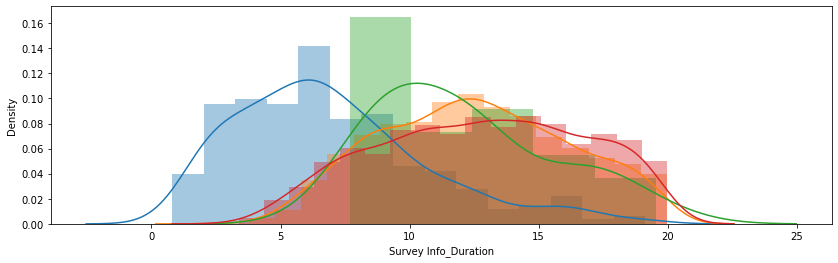

In [44]:
# exclude the lowest 10% in each survey group
cut_percentile = 10
data['cut_len'] = np.nan
group1durs = data['Survey Info_Duration'].loc[data['Survey Info_Group'] == 'neither']
low10_g1 = np.percentile(group1durs, cut_percentile)
print('Group 1:')
print('Lowest percentile under', low10_g1.round(1), 'min\n')
data['cut_len'] = np.where( (data['Survey Info_Group'] == 'neither') & (data['Survey Info_Duration'] <= low10_g1), 1, data['cut_len'])
sns.distplot(group1durs[group1durs < 20])

group2durs = data['Survey Info_Duration'].loc[data['Survey Info_Group'] == 'listening only']
low10_g2 = np.percentile(group2durs, cut_percentile)
print('Group 2:')
print('Lowest percentile under', low10_g2.round(1), 'min\n')
data['cut_len'] = np.where( (data['Survey Info_Group'] == 'listening only') & (data['Survey Info_Duration'] <= low10_g2), 1, data['cut_len'])
sns.distplot(group2durs[group2durs < 20])

group3durs = data['Survey Info_Duration'].loc[data['Survey Info_Group'] == 'performing only']
low10_g3 = np.percentile(group3durs, cut_percentile)
print('Group 3:')
print('Lowest percentile under', low10_g3.round(1), 'min\n')
data['cut_len'] = np.where( (data['Survey Info_Group'] == 'performing only') & (data['Survey Info_Duration'] <= low10_g3), 1, data['cut_len'])
sns.distplot(group3durs[group3durs < 20])

group4durs = data['Survey Info_Duration'].loc[data['Survey Info_Group'] == 'both']
low10_g4 = np.percentile(group4durs, cut_percentile)
print('Group 4:')
print('Lowest percentile under', low10_g4.round(1), 'min')
data['cut_len'] = np.where( (data['Survey Info_Group'] == 'both') & (data['Survey Info_Duration'] <= low10_g4), 1, data['cut_len'])
sns.distplot(group4durs[group4durs < 20])

In [45]:
# Drop participants we have flagged to cut
print(data['cut_len'].sum(), 'participants will be cut.\n')
print('Original data size:', data.shape)
data = data[data['cut_len'] != 1]
print('New data size:', data.shape)
data = data.drop(['cut_len','tmp_listening','tmp_performing'], axis=1)

data.reset_index(inplace = True, drop = True) # reset index after dropping rows

595.0 participants will be cut.

Original data size: (5907, 278)
New data size: (5312, 278)


### Screen based on repeat answers
Check if anyone just answered the same value down a matrix question. 
Cut participants who had 0 response range within each of the 3 sections (Activities, Playing functions, Listening functions), whenever that response was not '4' in all 3 sections.
Also cut those that responded 'I never do this' to all activities.

In [46]:
activities = [col for col in data.columns if col.startswith('Activities_')]

act_zero_std = (np.nanstd(data[activities],axis=1) == 0) 
act_not_same_as_before = data[activities].apply(lambda x: ~x.isin([4.,0.,99.,np.nan])).sum(axis=1) > 0
cut_activities_ids = data[act_zero_std & act_not_same_as_before].ID.unique().tolist()
print("cut activities:", len(cut_activities_ids))

cut activities: 31


In [47]:
listening = [col for col in data.columns if col.startswith('Music Listening_Functions') and col != 'Music Listening_Functions_Free Response']

list_zero_std = (np.nanstd(data[listening],axis=1) == 0) 
list_not_same_as_before = data[listening].apply(lambda x: ~x.isin([4.,0.,99.,np.nan])).sum(axis=1) > 0
cut_listening_ids = data[list_zero_std & list_not_same_as_before].ID.unique().tolist()
print("cut listening:", len(cut_listening_ids))

cut listening: 156


In [48]:
playing = [col for col in data.columns if col.startswith('Making Music_Functions') and col != 'Making Music_Functions_Free Response']

play_zero_std = (np.nanstd(data[playing],axis=1) == 0) 
play_not_same_as_before = data[playing].apply(lambda x: ~x.isin([4.,0.,99.,np.nan])).sum(axis=1) > 0
cut_playing_ids = data[play_zero_std & play_not_same_as_before].ID.unique().tolist()
print("cut playing:", len(cut_playing_ids))

cut playing: 104


In [49]:
cut_all = [cut_activities_ids, cut_listening_ids, cut_playing_ids]
drop_ids = set.intersection(*map(set,cut_all))
print("common IDs in all 3 subsets:", len(drop_ids))

cut_ids = list(set([y for x in cut_all for y in x]))
cut_ids.sort()

print("total people (rows) cut: ", len(cut_ids))

common IDs in all 3 subsets: 18
total people (rows) cut:  199


In [50]:
print('Original data size:', data.shape)

data = data[~data.ID.isin(cut_ids)]
print('New data size after cuts:', data.shape)

data.reset_index(inplace = True, drop = True) # reset index after dropping rows

Original data size: (5312, 275)
New data size after cuts: (5113, 275)


In [51]:
# look at number of participants by country
data.groupby(['Country_Country Name']).size()

Country_Country Name
France     983
Germany    872
India      891
Italy      892
UK         621
USA        854
dtype: int64

In [52]:
# Let's output stats about survey duration that we might want to report in a paper
# Median is likely most useful 
data['Survey Info_Duration'].agg(['min','max','mean','median','std']).round(1)

min          2.6
max       9041.7
mean        63.1
median      17.0
std        396.3
Name: Survey Info_Duration, dtype: float64

### This is the final RAW dataframe -- all columns, 99s and 0s kept, etc.

In [53]:
df = data[data.columns.difference(['ID','Date'])]
checking = df.describe(percentiles=[0.5]).T
checking['percent missing'] = (((len(df) - checking['count'])/len(df))*100).round(2)
checking = checking.loc[checking['percent missing'] >0,['percent missing','50%']].sort_values(['percent missing'], ascending=False)
checking

,percent missing,50%
Demographics_Health_Bored,47.90,4.0
Making Music_Functions_Stimulates Me Intellectually,41.15,4.0
Making Music_Functions_Gives Me Sense of Control,41.15,4.0
Making Music_Functions_Helps Me Dwell on My Worries,41.15,4.0
Making Music_Functions_Helps Me Concentrate,41.15,4.0
Making Music_Functions_Helps Me Accept My Situation,41.15,4.0
Making Music_Functions_Helps Keep a Routine,41.15,4.0
Making Music_Functions_Helps Distract Me,41.15,5.0
Making Music_Functions_Gives Meaning to My Life,41.15,4.0
Making Music_Functions_Feel Like Part of a Bigger Group,41.15,4.0


# Pre-processing/Recoding

In [54]:
# Recode gender to binary because of lack of representative data for 3 and 4 (0 = woman, 1 = man)
data['Demographics_General_Gender_binary'] = data['Demographics_General_Gender'].astype(str)
data = data.replace({'Demographics_General_Gender_binary': {'1.0': 0, '2.0': 1, 
                                                     '3.0': np.nan, '4.0': np.nan, 'nan': np.nan}})

In [55]:
# recoding 99s (missing) to nans; 0s (never do this/does not apply) to 4s (Does not change)
recoding_cols = [col for col in data.columns if 'Activities_' in col or '_Hypotheses_' in col 
                 or '_Functions_' in col or '_Situations_' in col 
                 or 'Music Listening_Formats_' in col] + ['Music Engagement_Diversity of Music', 'Music Engagement_Interest in Others Music', 'Music Engagement_Nostalgic Music']

data[recoding_cols] = data[recoding_cols].replace({99:np.nan, 0:4.})

In [56]:
# Drop columns that we're not using
drop_cols = [
         'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
         'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',
         'C7_Restrictions on internal movement', 'C8_International travel controls',
         'ContainmentHealthIndex', 
         'CountryName', 'Date',
         'Demographics_COVID_Current State', # only NYC
         'Demographics_COVID_Profession', # free text
         'Demographics_General_Years of Post-School', 'Demographics_General_Years of School', # combined in the 'Demographics_General_Education Years column'
         'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 'E4_International support',
         'ESM_Self-Generated Code', 
         'EconomicSupportIndex', 
         'GovernmentResponseIndex', 
         'H1_Public information campaigns', 'H2_Testing policy', 
         'H3_Contact tracing', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
         'ResponseId', 
         'StartDate', 
         'StringencyIndex', 'StringencyLegacyIndexForDisplay',
         'Survey Info_Duration', 'Survey Info_EndDate', 
         'Survey Info_Progress', 'Survey Info_RecordedDate', 'Survey Info_Source'
        ]
data = data.drop(columns = drop_cols, axis = 1)
data.reset_index(inplace = True, drop = True) 

In [57]:
# correlations
cor_real = data.corr()
cor_abs = data.corr().abs()
triangle = cor_real.where(np.triu(np.ones(cor_real.shape), k = 1).astype(np.bool))

cor = cor_abs.unstack()
cor = cor.sort_values(kind="quicksort", ascending = False)
cor = pd.DataFrame(cor)
cor.columns = ['cor']
cor = cor.query('cor < 1')

cor_high = cor.query('0.90 < cor < 1')
print((len(cor_high)/len(cor))*100, "% of correlations > 0.90 in the demographic data.")
print("Highest (absolute value) correlation is", cor['cor'].max())
cor_high

0.01159375483073118 % of correlations > 0.90 in the demographic data.
Highest (absolute value) correlation is 0.9405899349764323


,,cor
Country_Confirmed Cases,Country_Confirmed Deaths,0.940590
Country_Confirmed Deaths,Country_Confirmed Cases,0.940590
Country_Government Response Index,Country_Stringency Index,0.925485
Country_Stringency Index,Country_Government Response Index,0.925485
Country_Containment Health Index,Country_Government Response Index,0.925350
Country_Government Response Index,Country_Containment Health Index,0.925350


# Export data

#### Export Text Responses
Make a new dataframe (and export CSV file) of the free responses and then remove them from the quantitative data frame.

In [58]:
### New DataFrame of Free Responses
demo = ['Country_Country Name', 'Demographics_General_Age', 'Demographics_General_Gender', 'Demographics_Music_Ollen']
cleanedTextCols = ['ESM_ID'] + demo + free
free_responses = data[cleanedTextCols] # for claire

### map col values to something meaningful so that those working with it outside of coding environment don't need to look up values
# free_responses['Demographics_COVID_Current Country'] = free_responses['Demographics_COVID_Current Country'].map(local_dicts.answer_code_dict['Demographics_COVID_Current Country'])
free_responses['Demographics_General_Gender'] = free_responses['Demographics_General_Gender'].map(local_dicts.answer_code_dict['Demographics_General_Gender'])
free_responses['Demographics_Music_Ollen'] = free_responses['Demographics_Music_Ollen'].map(local_dicts.answer_code_dict['Demographics_Music_Ollen'])

In [59]:
# Print free responses to table and remove from quantitative data frame
free_responses.to_csv(r'free_responses.csv', index = None, header = True)
free_responses.to_excel(r'free_responses.xls', index = None, header = True)

# drop free responses in data
data = data.drop(['Demographics_COVID_Living Situation Free Response',
                  'Making Music_Examples_Free Response', 
                  'Making Music_Functions_Free Response', 
                  'Music Engagement_Other Ways Use Music Differently Free Response',
                  'Music Listening_Examples_Free Response',
                  'Music Listening_Functions_Free Response'], 
                 axis=1)

### Export final data table for future analyses
This is the data table LW and LF will use in all analyses for first CMQ paper (e.g. ranks, LGBM, FA)

In [60]:
data.shape

(5113, 234)

In [61]:
data.to_csv(r'cleaned_data.csv', index = None, header = True)